### NER

- word2vec, google-news-300
- bilstm
- crf

In [2]:
# import library
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [3]:
import pandas as pd
df = pd.read_csv(('data/ner_dataset.csv'),encoding = 'unicode_escape')
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [4]:
df['Sentence #']=df['Sentence #'].ffill()
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [5]:
df = df[['Sentence #','Word','Tag']]
df.rename(columns = {'Sentence #':'Sentence'},inplace = True)
df

C:\Users\tqin0\AppData\Local\Temp\ipykernel_12240\4266400182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'Sentence #':'Sentence'},inplace = True)


,Sentence,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O
1048573,Sentence: 47959,the,O


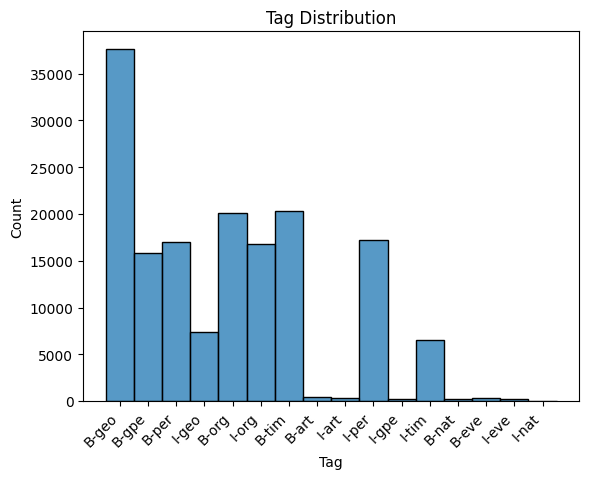

In [6]:
# show pos distribution
sns.histplot(df[df['Tag'] != 'O']['Tag'])
plt.xticks(rotation = 45, ha = 'right')
plt.title('Tag Distribution')
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Word      1048565 non-null  object
 2   Tag       1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [8]:
print('Unique sentences number - ' + str(df['Sentence'].nunique()))
print('Unique vocabs number - ' + str(df['Word'].nunique())) # 此时word中同时存在大小写

Unique sentences number - 47959
Unique vocabs number - 35177


Build model

In [9]:
import xml.etree.ElementTree as ET
# 一种以编程方式处理 XML 文档的方法

import tensorflow as tf

from tensorflow.keras.layers import TextVectorization
# 导入了 TextVectorization 层。这个层用于对文本数据进行预处理,将其转换为数字表示,
# 以便作为神经网络的输入

import gensim.downloader as api
# downloader 模块提供了一种下载预训练词嵌入的方法,词嵌入是对单词的数字化表示,
# 可以捕捉它们之间的语义和语法关系

from tensorflow.keras.layers import Embedding
# Embedding 层用于创建单词的密集的低维向量表示,可以作为神经网络的输入

tf.random.set_seed(123)
# 为 TensorFlow 的随机数生成器设置了种子为 123。这确保了任何随机操作,
# 如权重初始化或数据洗牌,在不同的运行中都是可重现的

In [10]:
df['Word'] = df['Word'].str.lower()
df.head()

C:\Users\tqin0\AppData\Local\Temp\ipykernel_12240\3681788111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Word'] = df['Word'].str.lower()


,Sentence,Word,Tag
0,Sentence: 1,thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [11]:
sentence_all = [(list(zip(group['Word'], group['Tag']))) for _, group in df.groupby('Sentence')]
sentence_all[0:2]
# sentence_all 变量存储了一个列表,列表中的每个元素都是一个句子中所有单词及其词性标注的列表
# 这段代码的作用是将 DataFrame 中的数据转换成一种更加适合后续自然语言处理任务的格式

[[('thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('london', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('british', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 [('iranian', 'B-gpe'),
  ('officials', 'O'),
  ('say', 'O'),
  ('they', 'O'),
  ('expect', 'O'),
  ('to', 'O'),
  ('get', 'O'),
  ('access', 'O'),
  ('to', 'O'),
  ('sealed', 'O'),
  ('sensitive', 'O'),
  ('parts', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('plant', 'O'),
  ('wednesday', 'B-tim'),
  (',', 'O'),
  ('after', 'O'),
  ('an', 'O'),
  ('iaea', 'B-org'),
  ('surveillance', 'O'),
  ('system', 'O'),
  ('begins', 'O'),
  ('functioning', 'O'),
  ('.', 'O')]]

In [45]:
# check whether GPU resouce existed
if tf.test.is_gpu_available():
    BATCH_SIZE = 512
    # Number of examples used in each iteration，
    # batch size决定了每次参数更新时使用的样本数量，
    # 较小的batch size能提供更精确的梯度估计，但需要更多的迭代次数才能收敛；大的batch size则相反

    EPOCHS = 5
    # Number of passes through entire dataset
    # epoch则决定了整个训练数据集被完整训练的次数
    # 增加epoch可让神经网络更好的学习数据的特征和规律，但过大的epoch易导致过拟合

    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
    print(
        '% GPU resource is applied.'
    )
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20
    print(
        '% CPU resource is applied.'
    )

% CPU resource is applied.


In [46]:
len(tf.config.list_physical_devices('GPU'))

0

In [20]:
# remove duplicates
words = list(set(df['Word'].values))
tags = list(set(df['Tag'].values))

print('words length:',len(words))
print('tags length:',len(tags))

words length: 31818
tags length: 17


In [21]:
# 这段代码用于创建单词到索引（word to index）和标签到索引（tag to index）的映射关系
import sklearn

# 单词到索引的映射,('kutuny', 2) | 索引从2开始，索引0、1被保留用作特殊用途
# len(word2idx) = 31820
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# 索引到单词的映射,(2, 'kutuny')
idx2word = {i: w for w, i in word2idx.items()}

# 标签到索引的映射，('I-per': 1)
# len(tag2idx) = 18
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# 索引到标签的映射，(1: 'I-per')
idx2tag = {i: w for w, i in tag2idx.items()}

In [40]:
# save pre-trained model to local. Windows: C:\Users\<username>\gensim-data\word2vec-google-news-300
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")


In [39]:
# load local pre_trained model
# import gensim.models
# model = gensim.models.KeyedVectors.load('word2vec-google-news-300.model')

# print("Vocabulary size:", len(model.wv.key_to_index))
# print("Vector size:", model.wv.vector_size)

In [41]:
# 将单词矩阵嵌入（Embedding）成一个词向量矩阵
hits = 0
misses = 0

# word2vec = api.load("word2vec-google-news-300")
word2vec

embedding_dim = 300
# 导入词向量。使用 api.load("word2vec-google-news-300") 导入了一个名为 "word2vec-google-news-300" 的
# 词向量模型。这个词向量模型可以将单词映射为300维的向量表示。

# 创建了一个名为 embedding_matrix 的零矩阵，其大小为 (len(word2idx), embedding_dim)，
# 其中 len(word2idx) 表示单词到索引的映射关系中的单词数量，embedding_dim 表示每个单词的
# 嵌入维度（这里是300）
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

# 使用 zip(word2idx.keys(), word2idx.values()) 遍历了单词到索引的映射关系中的每个单词和对应的索引。
# 对于每个单词，尝试从导入的词向量模型中获取对应的词向量 embedding_vector = word2vec[word]
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
# 如果成功获取到了词向量，将其赋值给 embedding_vector，并将其保存在 embedding_matrix 的对应索引位置上。
# 如果无法获取词向量（例如，该单词不在词向量模型中），则将 embedding_vector 保持为 None。
# 对于获取到词向量的情况，将 hits 计数加一；对于无法获取词向量的情况，将 misses 计数加一。

print("Converted %d words (%d misses)" % (hits, misses))

Converted 19600 words (12220 misses)


In [48]:
embedding_matrix.shape

(31820, 300)

In [49]:
# 这段代码的作用是将词语和标签转换为索引，并对句子进行填充，
# 以便在进行模型训练和预测之前，将它们转换为适合输入神经网络的格式。

# 代码导入了 pad_sequences 函数，该函数用于对序列进行填充以保证它们具有相同的长度
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
# (将句子转化为索引序列) 创建了一个名为 X 的列表，其中包含了将每个句子中的单词转换为对应索引的序列。
# 对于每个句子 s，使用列表推导式将句子中的每个单词 w[0] 转换为对应的索引 word2idx[w[0]]，
# 并将其添加到 X 中
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
# (对句子进行填充)
# 使用 pad_sequences 函数对句子进行填充，确保它们具有相同的长度。
# maxlen 参数指定了填充后的句子长度。
# sequences 参数传入了待填充的序列列表 X。
# padding 参数设置为 "post"，表示在序列末尾进行填充。
# value 参数传入了填充使用的值，这里使用了索引为 "PAD" 的特殊值。
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index（将标签转化为索引序列）
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght（对标签进行填充）
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])

# 对于列表 y 中的每个序列 i，使用 to_categorical 函数将其转换为一个独热编码的序列，
# 其中类别数量为 len(tags)+1，加一是因为还有一个特殊的 "PAD" 类别
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)


from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

# 打印原始样本中的单词序列和标签序列
print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )

# 打印经过处理后的样本和标签所以序列
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

# 这段代码的目的是将原始的文本数据转换为可以用于训练和测试神经网络的格式。
# 通过将文本转换为索引序列，并对序列进行填充和独热编码处理，为后续的序列标注任务（如命名实体识别）
# 提供了适当的输入和标签数据。打印结果部分展示了数据处理前后的对比，以便查看转换的效果。

Raw Sample:
  iranian officials say they expect to get access to sealed sensitive parts of the plant wednesday , after an iaea surveillance system begins functioning .

 
Raw Label:
  B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O

 
After processing, sample:
 [26485 27393 31001  1927 19439 27017 20971  8697 12383  5663 27674 28822
 18210  7164  2185  5663 26363 27393 11249 18242 28051 15609 31268 12272
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [50]:
len(y[0][0])

18

In [51]:
X[0:2]

array([[26485, 27393, 31001,  1927, 19439, 27017, 20971,  8697, 12383,
         5663, 27674, 28822, 18210,  7164,  2185,  5663, 26363, 27393,
        11249, 18242, 28051, 15609, 31268, 12272,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [17129, 24013, 19329,  5729,  6936,  8697, 26541, 22722,  8697,
        27352, 23576, 21300, 27393,  5663, 20096,  9806,    98,  7974,
        20295, 15535, 12322, 12277,  7504,  1529, 12272,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     

In [52]:
y[0:2]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]])]